<a href="https://colab.research.google.com/github/ivanpalenciab/Sentiment-analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install pyarrow
%pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from textwrap import wrap
from joblib import dump, load
import seaborn as sns

In [ ]:
RANDOM_SEED = 30
MAX_LEN = 200
FILE_ROUTE = "/content/drive/MyDrive/Sentiment analysis/Datos/"
BATCH_SIZE = 16
NCLASSES = 3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#First dataset Import
df= pd.read_parquet(f"{FILE_ROUTE}spanish%2Fmultilingual-sentiments-train.parquet")
df.drop("source",axis=1,inplace=True)

In [ ]:
#Second dataframe imported
df_2 = pd.read_parquet(f"{FILE_ROUTE}spanish%2Fmultilingual-sentiments-test.parquet")
df_2.drop("source",axis=1,inplace=True)

In [ ]:
df_sampled = df_2.groupby('label').sample(n=80, random_state=RANDOM_SEED)
df_train = pd.concat([df, df_sampled])
test_df = df_2.drop(df_sampled.index)

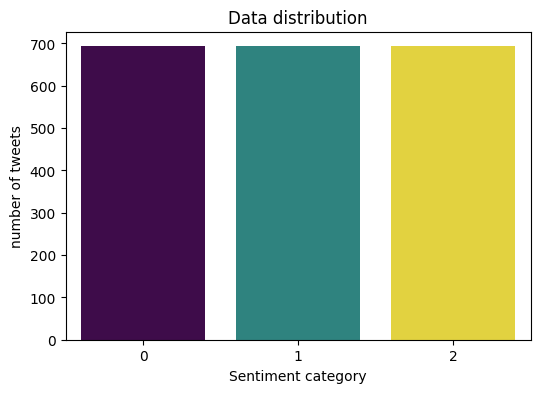

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df_train["label"], hue=df_train["label"], palette="viridis", legend=False)

# Etiquetas y título
plt.xlabel("Sentiment category")
plt.ylabel("number of tweets")
plt.title("Data distribution")

# Mostrar gráfico
plt.show()

In [ ]:
print(f"porcentaje de datos de testeo {round(test_df.shape[0]/df_train.shape[0]*100)} %")

porcentaje de datos de testeo 30 %


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2079 entries, 0 to 804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2079 non-null   object
 1   label   2079 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.7+ KB


In [ ]:
df_train["label"].unique()


array([2, 1, 0])

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, 2 to 869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    630 non-null    object
 1   label   630 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ KB


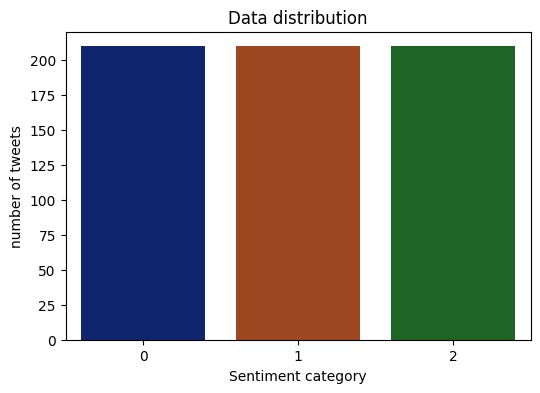

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=test_df["label"], hue=test_df["label"], palette="dark", legend=False)

# Etiquetas y título
plt.xlabel("Sentiment category")
plt.ylabel("number of tweets")
plt.title("Data distribution")

# Mostrar gráfico
plt.show()

In [ ]:
#tokenitation
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [ ]:
# tokenitation example
sample_txt = '¡realmente me gusta la hamburguesa!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  ¡realmente me gusta la hamburguesa!
Tokens:  ['¡', 'realmente', 'me', 'gusta', 'la', 'hamburguesa', '!']
Tokens numéricos:  [1139, 3189, 1129, 2816, 1030, 27035, 1127]


In [ ]:
# Codificactio to introduce in BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 11,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding='max_length',
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', '¡', 'realmente', 'me', 'gusta', 'la', 'hamburguesa', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([    4,  1139,  3189,  1129,  2816,  1030, 27035,  1127,     5,     1,
            1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [ ]:
#dataset creation
class my_dataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.label[item]
    encoding = tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding="max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = my_dataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 2)

In [ ]:
train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
#Model
class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids = input_ids,attention_mask = attention_mask)
    cls_output = outputs.pooler_output
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [ ]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
#training
EPOCHS = 5
optimizer = optim.AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Training iterataion
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(test_df)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 20
------------------
Entrenamiento: Loss: 0.3419579356013296, accuracy: 0.9023569023569024
Validación: Loss: 1.3124424993991852, accuracy: 0.653968253968254

Epoch 2 de 20
------------------
Entrenamiento: Loss: 0.2240769714036455, accuracy: 0.9389129389129389
Validación: Loss: 1.5333614697679878, accuracy: 0.6857142857142857

Epoch 3 de 20
------------------
Entrenamiento: Loss: 0.11609524397063069, accuracy: 0.9663299663299664
Validación: Loss: 1.6358292929828167, accuracy: 0.7

Epoch 4 de 20
------------------
Entrenamiento: Loss: 0.09978446335679529, accuracy: 0.975949975949976
Validación: Loss: 1.8116422861814498, accuracy: 0.6841269841269841

Epoch 5 de 20
------------------
Entrenamiento: Loss: 0.1020598714605932, accuracy: 0.9730639730639731
Validación: Loss: 1.9940496906638145, accuracy: 0.6857142857142857

Epoch 6 de 20
------------------
Entrenamiento: Loss: 0.04110589095496554, accuracy: 0.9874939874939875
Validación: Loss: 2.2805032834410666, accuracy: 0.679365

KeyboardInterrupt: 

In [ ]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
       padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  prediction = torch.argmax(output, dim=1)   # Obtener la clase con mayor probabilidad

  # Mapeo de clases según la nueva clasificación de tres categorías
  sentiment_labels = {0: "Positivo", 1: "Neutral", 2: "Negativo"}

  print("\n".join(wrap(review_text)))
  print(f'Sentimiento predicho: {sentiment_labels[prediction.item()]}')

In [ ]:
#text = "esta fue una experiancia bastante desagradables, esperaba algo mejor."
text ="la peor experiencia de mi vida"

classifySentiment(text)

la peor experiencia de mi vida
Sentimiento predicho: Negativo


In [ ]:
ROUTE = "/content/drive/MyDrive/Sentiment analysis/Models/"
#torch.save(model.state_dict(), "BERTo_model_parameters.pth")
#torch.save(model, f"{ROUTE}/BERTo_model.pth")
#to follow tunning
#torch.save({"modelo_state_dict":model.state_dict,
 #           "optimizer_state_dict":optimizer.state_dict},"checkpoint.pth")

**Nota:** Quiero probar eliminando del set de testeo los twitts de etiqueta neutra a ver si estos son los que no esta clasificando bien.

In [ ]:
test_df_no_neu = test_df[test_df["label"]!=1]
test_df_no_neu.head()

,text,label
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,0
8,@user pues no está nada mal,0
9,"@user quizá para profesionales no sea mucho,pe...",2
11,Hora de seguir soñando muy bonito,0
14,La felicidad tiene un nombr #Tailandia Si es ...,0


In [ ]:
ROUTE = "/content/drive/MyDrive/Sentiment analysis/Models/"

try:
  charged_model = load(f"{ROUTE}/BERTo_model.joblib")
except:
  charged_model = torch.load(f"{ROUTE}/BERTo_model.joblib", map_location=torch.device('cpu'))

#model = BERTSentimentClassifier(NCLASSES)
#model = model.to(device)